In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, DataStructs, Draw

# Molecular Fingerprint

                   A: 15
                   B: 28
               A & B: 11
Tanimoto Coefficient: 0.34375
    Dice Coefficient: 0.5116279069767442


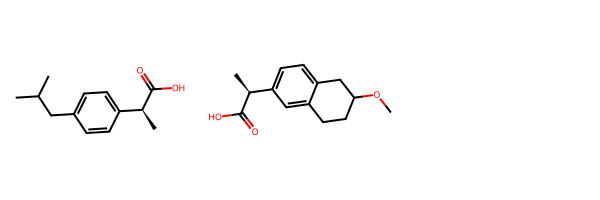

In [2]:
m1 = Chem.MolFromSmiles('CC(C)CC1=CC=C([C@H](C)C(O)=O)C=C1')         # (S)-(+)-Ibuprofen
m2 = Chem.MolFromSmiles('OC([C@@H](C)C1=CC=C2C(CCC(OC)C2)=C1)=O')    # (S)-(+)-Naproxen

f1 = rdMolDescriptors.GetMACCSKeysFingerprint(m1)
f2 = rdMolDescriptors.GetMACCSKeysFingerprint(m2)

print(f'                   A: {f1.GetNumOnBits()}')
print(f'                   B: {f2.GetNumOnBits()}')
print(f'               A & B: {(f1 & f2).GetNumOnBits()}')
print(f'Tanimoto Coefficient: {DataStructs.FingerprintSimilarity(f1, f2)}')
print(f'    Dice Coefficient: {DataStructs.DiceSimilarity(f1, f2)}')

Draw.MolsToGridImage([m1, m2], useSVG=True)

                   A: 16
                   B: 16
               A & B: 16
Tanimoto Coefficient: 1.0
    Dice Coefficient: 1.0


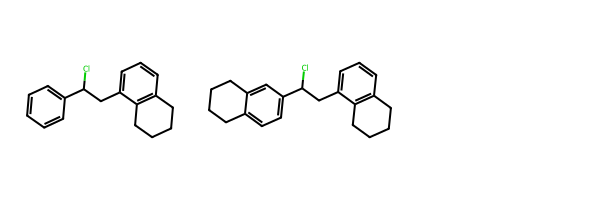

In [3]:
m3 = Chem.MolFromSmiles('ClC(CC1=CC=CC2=C1CCCC2)C3=CC=CC=C3')
m4 = Chem.MolFromSmiles('ClC(CC1=CC=CC2=C1CCCC2)C3=CC=C4C(CCCC4)=C3')

f3 = rdMolDescriptors.GetMACCSKeysFingerprint(m3)
f4 = rdMolDescriptors.GetMACCSKeysFingerprint(m4)

print(f'                   A: {f3.GetNumOnBits()}')
print(f'                   B: {f4.GetNumOnBits()}')
print(f'               A & B: {(f3 & f4).GetNumOnBits()}')
print(f'Tanimoto Coefficient: {DataStructs.FingerprintSimilarity(f3, f4)}')
print(f'    Dice Coefficient: {DataStructs.DiceSimilarity(f3, f4)}')

Draw.MolsToGridImage([m3, m4], useSVG=True)

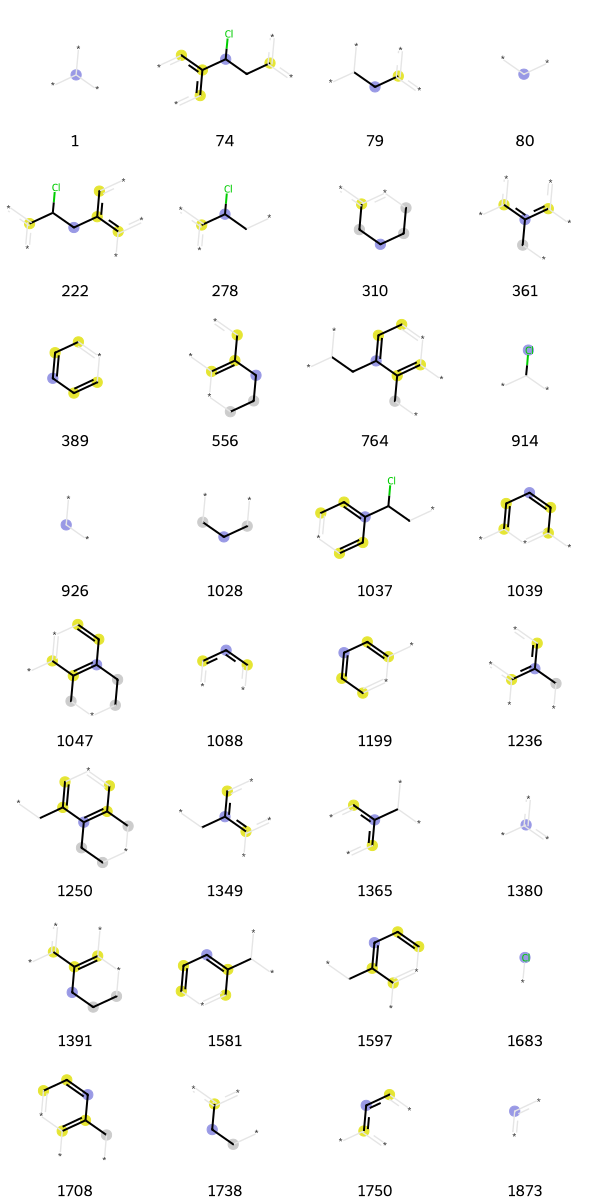

In [4]:
bi = {}
fp_morgan3 = rdMolDescriptors.GetMorganFingerprintAsBitVect(m3, radius=2, bitInfo=bi)
tpls = [(m3, x, bi) for x in fp_morgan3.GetOnBits()]
Draw.DrawMorganBits(tpls, molsPerRow=4, legends=[str(x) for x in fp_morgan3.GetOnBits()], useSVG=True)

# Similarity Coefficient

In [5]:
BitsSetTable256 = np.zeros(256)
for i in range(256):
    BitsSetTable256[i] = (i & 1) + BitsSetTable256[i // 2]

def countSetBits(n):
    return (BitsSetTable256[n & 0xff] +
            BitsSetTable256[(n >> 8) & 0xff] +
            BitsSetTable256[(n >> 16) & 0xff] +
            BitsSetTable256[(n >> 24) & 0xff])

tc_matrix = np.zeros((256, 256))
dc_matrix = np.zeros((256, 256))

## Tanimoto Coefficient

$$
\begin{aligned}
Tc(A, B) &= \dfrac{|A \cap B|}{|A \cup B|}\\
&= \dfrac{|A \cap B|}{|A| + |B| - |A \cap B|}\\
&= \dfrac{|A \cap B|}{|A| - |A \cap B| +  | B| - |A \cap B| + |A \cap B|}
\end{aligned}
$$

In [6]:
def tc(n1: np.int16, n2: np.int16):
    c = countSetBits(n1 & n2)
    a = countSetBits(n1)
    b = countSetBits(n2)
    return c / (a + b - c)

tc(15, 16), tc(14, 15)

(0.0, 0.75)

## Tversky Coefficient

$$
Tv(A, B) = \dfrac{|A \cap B|}{\alpha(|A| - |A \cap B|) +  \beta(| B| - |A \cap B|) + |A \cap B|}
$$

For $\alpha^\prime = k\alpha, \beta^\prime = k\beta$

$$
Tv_{\alpha^\prime, \beta^\prime} (A, B) = \dfrac{1}{\dfrac{k}{Tv_{\alpha, \beta} (A, B)} + 1 - k}
$$

## Dice Coefficient

For $\alpha = 0.5, \beta = 0.5$ of Tversky Coefficient

$$
Dc(A, B) = \dfrac{|A \cap B|}{0.5 (|A| + |B|)}
$$

We can conclude that $Dc \geq Tc$. We know that $|A \cap B| \leq |A|, |A \cap B| \leq |B|$, so $|A| + |B| - |A \cap B| \geq |A|$, and $|A| + |B| - |A \cap B| \geq |B|$, so $2(|A| + |B| - |A \cap B|) \geq |A| + |B|$, identity to $|A| + |B| - |A \cap B| \geq 0.5(|A| + |B|)$, so $Tc \leq Dc$

Also, 

$$
Tc = \dfrac{Dc}{2 - Dc}
$$

In [7]:
def dc(n1, n2):
    c = countSetBits(n1 & n2)
    a = countSetBits(n1)
    b = countSetBits(n2)
    return 2 * c / (a + b)

dc(15, 16), dc(14, 15)

(0.0, 0.8571428571428571)

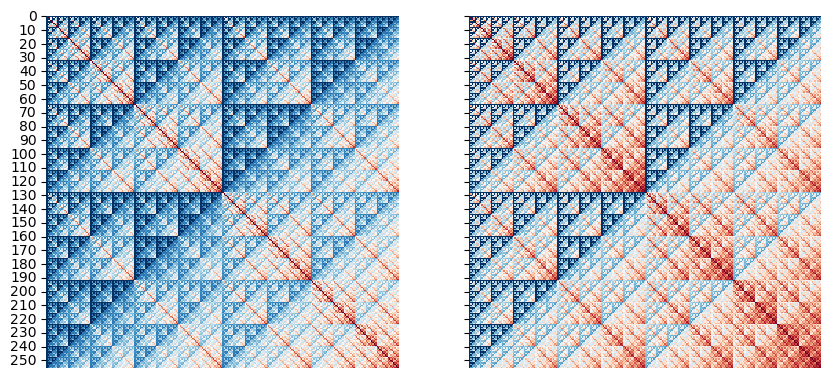

In [8]:
for i in range(1, 256):
    for j in range(1, 256):
        tc_matrix[i][j] = tc(i, j)
        dc_matrix[i][j] = dc(i, j)

_, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.heatmap(data=tc_matrix, square=True, cmap='RdBu_r', ax=axs[0], cbar=False, xticklabels='')
sns.heatmap(data=dc_matrix, square=True, cmap='RdBu_r', ax=axs[1], cbar=False, xticklabels='')
plt.show()

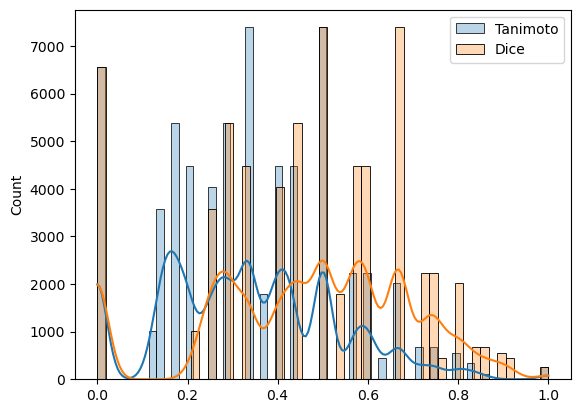

In [9]:
sns.histplot(tc_matrix.flatten(), alpha=0.3, kde=True, label='Tanimoto')
sns.histplot(dc_matrix.flatten(), alpha=0.3, kde=True, label='Dice')
plt.legend()
plt.show()

Larger molecules will cause higher similarity, because the fingerprint density $\rho_{FP}$ will increase. Several methods can be used to balance or eliminate the compound complexity.

- equally taking into account bits that are set on or off in similarity calculations
- combine with fingerprint complement